In [1]:
import numpy as np
import script.model.bonds as bd
import script.model.model as sim
import script.model.utility as utl
import copy
import scipy.special as spe
from importlib import reload
import matplotlib.pyplot as plt

from scipy.special import binom



In [62]:
reload(sim)
prm0 = sim.prm_dict.copy()

prm0["scheme"] = "step"
prm0["tc"] = 0
prm0["l0_list"] = [100, 0]
prm0["f0"] = 10 
prm0["elist"] = [100, 10, 100, 10]
prm0["ton"] = 1e20
prm0['tm'] = 1e4


In [88]:
prm0["elist"] = [100, 13, 100, 10]
sto1 = sim.Stoch(prm_dict=prm0)

prm0["elist"] = [100, 14, 100, 10]
sto2 = sim.Stoch(prm_dict=prm0)


In [89]:
t1, spec1 = sto1.run1(output=True, storeData=True)
t2, spec2 = sto2.run1(output=True, storeData=True)
pass

Info:
  Init population: [APC-Ag-BCR, Ag-BCR] =  [100, 0, 0, 0]
  reaction rate: 
  Bond	APC	BCR
unfinished!
current time:  23623.869308601992
current step:  4
(5, 1) (5, 4)
96.0
Info:
  Init population: [APC-Ag-BCR, Ag-BCR] =  [100, 0, 0, 0]
  reaction rate: 
  Bond	APC	BCR
unfinished!
current time:  21615.08680818651
current step:  1
(2, 1) (2, 4)
99.0


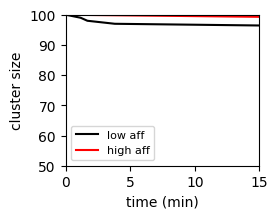

In [90]:
fig, ax = plt.subplots(figsize=(2.5, 2), dpi=100)
plt.plot(t1/1e3, spec1[:, 0], '-k')
plt.plot(t2/1e3, spec2[:, 0], '-r')
ax.set(xlim=(0, 15), ylim=(50, 100), xlabel='time (min)', ylabel='cluster size')
plt.legend(['low aff', 'high aff'], fontsize=8)
plt.show()

In [37]:
def GetAcc(eb_list, prm, n=200, output=False, num_competes=1):
    """
        args:
            eb_list: affinity distribution of B cells
            prm: default parameter (fixing other parameters)
            n: number of trails
        return:
            acc: the probability to rank the best B cell highest
    """
    nacc_count = 0
    tacc_count = 0
    macc_count = 0
    best_id = np.argmax(eb_list)
    
    num_cell = len(eb_list)
    sto_list = []
    for i, eb in enumerate(eb_list):
        sto_list.append(sim.Stoch(copy.deepcopy(prm)))
        sto_list[i].prm_dict["elist"][1] = eb
        sto_list[i].setup()
        sto_list[i].loadSharing=False
    if output:
        print("*"*15)
        print("init complete")
        print("eblist", eb_list)
        print("best id=", best_id)
        print("check eb:", end="  ")
        for stoi in sto_list:
            print("{0:.2f}".format(stoi.bonds.elist[1]), end=", ")
        print("")
    for i in range(n):
        nag_list = np.zeros(num_cell)
        tend_list = np.zeros(num_cell)
        m_list = np.zeros(num_cell)
        if output and i>1:
            sim.printProgress(i, n)
        for j, stoi in enumerate(sto_list):
            stoi.setup()
            nag, tend = stoi.run1(output=False, storeData=False)
            nag_list[j] = nag[0]
            tend_list[j]= tend
            m_list[j] = stoi.spec_record[0]
            #if np.isnan(nag[0]):
            #    print("simulation not finished!")
            #    return np.nan, np.nan
        #if best_id == np.random.choice(np.flatnonzero(nag_list == nag_list.max())): #np.argmax(nag_list):
        #    nacc_count += 1

        #if best_id == np.argmax(tend_list):
        #    tacc_count += 1

        if best_id == np.random.choice(np.flatnonzero(
            m_list == m_list.max()
        )):
            macc_count +=1
        
        if output and i==1:
            print("example 1:")
            print("macc_count = ", macc_count)
    
    if output:
        print("")
        print("macc_count=",macc_count )
    return macc_count / n

def positive_rate(nc, x, n):
    s = 0
    for i in range(nc, n+1):
        s += spe.binom(n, i)*x**i/(1+x)**n
    return s

def acc_n(x, n, alpha):
    s = 0
    for nc in range(n+1):
        s += (positive_rate(nc, alpha*x, n) - positive_rate(nc + 1, alpha*x, n)) *\
        (positive_rate(nc, x, n) + positive_rate(nc + 1, x, n))/2.0
    return s

def tau(ta, tb, f=0, xa=1.5, xb=2.0):
    return ta*tb*np.exp(-f*(xa+xb)/4.012)/(ta*np.exp(-f*xa/4.012) + tb*np.exp(-f*xb/4.012))

def acc_t(x, n, alpha):
    def integrand(y):
        r = tau(1, alpha*x)/tau(1, x)
        return (1-y**r)**n * (1-y)**(n-1)
    
    return 1- n*(quad(integrand, 0, 1)[0])


class scan_eb1:
    
    def __init__(self, n=200):
        self.numRun = n
        self.init_dis = "random" ## or fixed
        self.prmlist = []
        self.m_error_list, self.m_error_std_list = [], []
        pass
    
    def run_eb(self, prm, eblist = np.arange(0, 11, 1), dE=0.2, num_cell=5, output=False):
        for eb in eblist:
            self._run(prm, eb, dE, num_cell, output=output)
            self.prmlist.append(eb)
        #return self.prmlist, self.nerror_list, self.nerror_std_list, self.terror_list, self.terror_std_list
        return
    
    def _run(self, prm, eb, dE, num_cell, num_run = 10, output=False):
        m_error_tmp = []
        if self.init_dis=="fixed":
            eb_distribution =[eb]*(num_cell-1) + [eb+dE]
        elif self.init_dis == "uniform":
            eb_distribution = np.linspace(eb-dE, eb, num_cell)
        for j in range(num_run):
            if self.init_dis=="random":
                eb_distribution = np.random.normal(eb, dE, num_cell)
            sim.printProgress(j, num_run)
            m_error = GetAcc(eb_distribution, prm, n= self.numRun, output=output)
            m_error_tmp.append(m_error)
        self.m_error_list.append(np.mean(m_error_tmp))
        self.m_error_std_list.append(np.std(m_error_tmp))
        print("eb1={0:.2f}, de={1:.2f},  m acc={2:.3f}[{3:.4f}]".
                  format(
                      eb, dE, np.mean(m_error_tmp),np.mean(m_error_tmp), 
                  ))
        return
    
    def run_de(self, prm, delist = np.linspace(0, 1, 11), eb=5, num_cell = 5, output=False):
        
        for de in delist:
            self._run(prm, eb, de, num_cell, output=output)
            self.prmlist.append(de)
        return
    
    def run_nb(self, prm, nBlist = np.arange(2, 15, 1, dtype=int), eb=5, dE=0.3, output=False):
        for nb in nBlist:
            self._run(prm, eb, dE, nb, output=output)
            self.prmlist.append(nb)
        return

In [38]:
prm0["l0_list"] = [20, 0]
seE2_comp_n20 = scan_eb1()
seE2_comp_n20.numRun = 500
seE2_comp_n20.init_dis = "fixed"
seE2_comp_n20.run_eb(prm0, eblist = np.arange(5, 20.5, 1.0), num_cell=2, dE=0.1)




eb1=5.00, de=0.10,  m acc=0.499[0.4992]................90%
eb1=6.00, de=0.10,  m acc=0.498[0.4982]................90%
eb1=7.00, de=0.10,  m acc=0.523[0.5226]................90%
eb1=8.00, de=0.10,  m acc=0.498[0.4984]................90%
eb1=9.00, de=0.10,  m acc=0.498[0.4978]................90%
eb1=10.00, de=0.10,  m acc=0.496[0.4958]...............90%
eb1=11.00, de=0.10,  m acc=0.502[0.5018]...............90%
eb1=12.00, de=0.10,  m acc=0.503[0.5032]...............90%
eb1=13.00, de=0.10,  m acc=0.581[0.5810]...............90%
eb1=14.00, de=0.10,  m acc=0.598[0.5976]...............90%
eb1=15.00, de=0.10,  m acc=0.551[0.5512]...............90%
eb1=16.00, de=0.10,  m acc=0.538[0.5380]...............90%


In [53]:
prm0["l0_list"] = [20, 0]
prm0['tm'] = 1e3
seE2_n20_t2 = scan_eb1()
seE2_n20_t2.numRun = 500
seE2_n20_t2.init_dis = "fixed"
seE2_n20_t2.run_eb(prm0, eblist = np.arange(5, 16.5, 1.0), num_cell=2, dE=0.1)



eb1=5.00, de=0.10,  m acc=0.509[0.5088]................90%
eb1=6.00, de=0.10,  m acc=0.497[0.4974]................90%
eb1=7.00, de=0.10,  m acc=0.491[0.4912]................90%
eb1=8.00, de=0.10,  m acc=0.490[0.4902]................90%
eb1=9.00, de=0.10,  m acc=0.502[0.5020]................90%
eb1=10.00, de=0.10,  m acc=0.504[0.5036]...............90%
eb1=11.00, de=0.10,  m acc=0.591[0.5908]...............90%
eb1=12.00, de=0.10,  m acc=0.578[0.5782]...............90%
eb1=13.00, de=0.10,  m acc=0.563[0.5626]...............90%
eb1=14.00, de=0.10,  m acc=0.534[0.5340]...............90%
eb1=15.00, de=0.10,  m acc=0.517[0.5166]...............90%
eb1=16.00, de=0.10,  m acc=0.515[0.5152]...............90%


In [56]:
seE2_n20_t2.run_eb(prm0, eblist = np.arange(17, 20.5, 1.0), num_cell=2, dE=0.1)



eb1=17.00, de=0.10,  m acc=0.503[0.5034]...............90%
eb1=18.00, de=0.10,  m acc=0.504[0.5036]...............90%
eb1=19.00, de=0.10,  m acc=0.497[0.4970]...............90%
eb1=20.00, de=0.10,  m acc=0.501[0.5006]...............90%


In [51]:

def make_plot(seE, nB, dE=0.1, N=100, ea=10, f0=0, ylim=(0, 1), show_comp=False):
    delist = np.linspace(-5, 5, 100)
    fig, ax = plt.subplots(figsize=(3.5, 2.3), dpi=200)
    ax.errorbar(np.asarray(seE.prmlist), seE.m_error_list, yerr=seE.m_error_std_list, fmt='-oC0', ms=3, capsize=3)
    
    ax.set(xlim=(5, 20), ylim=ylim)
    ax.set(xlabel="B cell affinity $E_b$ (kT)", ylabel="fidelity")
    plt.tight_layout()
    
    plt.show()
    
#make_plot(seE5, 5, N=200)

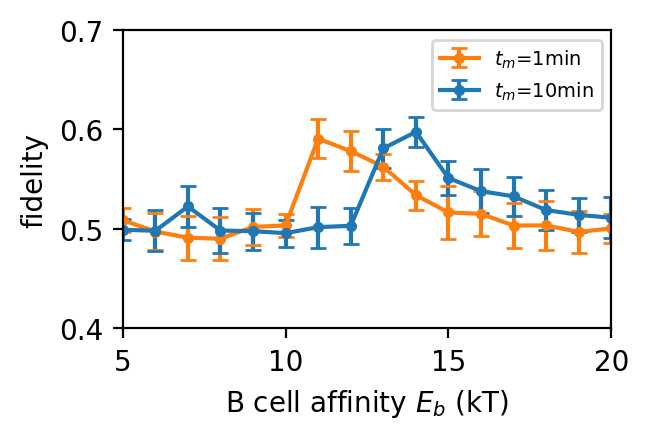

In [91]:
# make_plot(seE2_comp_n20, 2, ylim=(0.4, 0.8))
fig, ax = plt.subplots(figsize=(3.5, 2.3), dpi=200)
ax.errorbar(np.asarray(seE2_n20_t2.prmlist), seE2_n20_t2.m_error_list, yerr=seE2_n20_t2.m_error_std_list, fmt='-oC1', ms=3, capsize=3)
ax.errorbar(np.asarray(seE2_comp_n20.prmlist), seE2_comp_n20.m_error_list, yerr=seE2_comp_n20.m_error_std_list, fmt='-oC0', ms=3, capsize=3)


ax.set(xlim=(5, 20), ylim=(0.4, 0.7))
ax.set(xlabel="B cell affinity $E_b$ (kT)", ylabel="fidelity")
plt.legend(['$t_m$=$1$min', '$t_m$=$10$min'], fontsize=7)
plt.tight_layout()
